In [1]:
import sys
sys.path.append('..')

from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
from src.models.cnn import GoogleNetFT

In [3]:
model = GoogleNetFT(num_classes=10, requires_grad=True)
model

GoogleNetFT(
  (model): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn):

In [4]:
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir: Path):
        self.samples = []

        for file in root_dir.glob("*.png"):
            label = int(file.stem.split("_")[0])
            self.samples.append((file, label))

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # for visualization (inverse of normalize)
        self.inv_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        )


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        image = self.transform(image)
        return image, label

    def show_image(self, idx):
        img_path, label = self.samples[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # undo normalization for display
        image = self.inv_normalize(image)
        image = torch.clamp(image, 0, 1)

        plt.figure(figsize=(4, 4))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Spectrogram | label={label}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [5]:
from torch.utils.data import DataLoader
import os

cwd = Path(os.getcwd()).parent
dataset = SpectrogramDataset(Path(cwd, "data", "audio", "spec"))

In [6]:
import torch
from torch.utils.data import random_split

N = len(dataset)

train_size = int(0.6 * N)
val_size = int(0.2 * N)
test_size = N - train_size - val_size  # avoids rounding bugs

In [7]:
generator = torch.Generator().manual_seed(42)

train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=generator
)

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


In [9]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


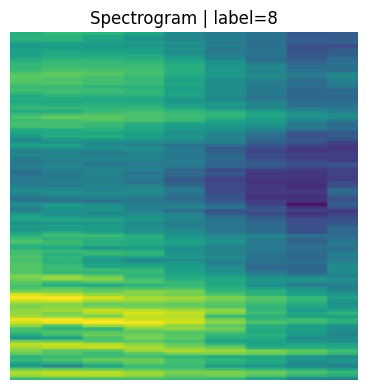

In [10]:
dataset.show_image(5)

### Training

In [11]:
## Training the model
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

In [13]:
@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


In [14]:
num_epochs = 10
best_val_loss = float("inf")

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.3f}"
    )

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()  # optional but smart

Epoch 01 | Train Loss: 0.9741, Train Acc: 0.707 | Val Loss: 0.5905, Val Acc: 0.797
Epoch 02 | Train Loss: 0.2095, Train Acc: 0.941 | Val Loss: 0.2457, Val Acc: 0.912
Epoch 03 | Train Loss: 0.1091, Train Acc: 0.969 | Val Loss: 0.2544, Val Acc: 0.912
Epoch 04 | Train Loss: 0.0337, Train Acc: 0.994 | Val Loss: 0.0872, Val Acc: 0.975
Epoch 05 | Train Loss: 0.0203, Train Acc: 0.996 | Val Loss: 0.0739, Val Acc: 0.977
Epoch 06 | Train Loss: 0.0385, Train Acc: 0.989 | Val Loss: 0.1826, Val Acc: 0.942
Epoch 07 | Train Loss: 0.0692, Train Acc: 0.981 | Val Loss: 0.1617, Val Acc: 0.960
Epoch 08 | Train Loss: 0.0403, Train Acc: 0.991 | Val Loss: 0.1570, Val Acc: 0.957
Epoch 09 | Train Loss: 0.0165, Train Acc: 0.998 | Val Loss: 0.0666, Val Acc: 0.977
Epoch 10 | Train Loss: 0.0402, Train Acc: 0.989 | Val Loss: 0.1608, Val Acc: 0.952


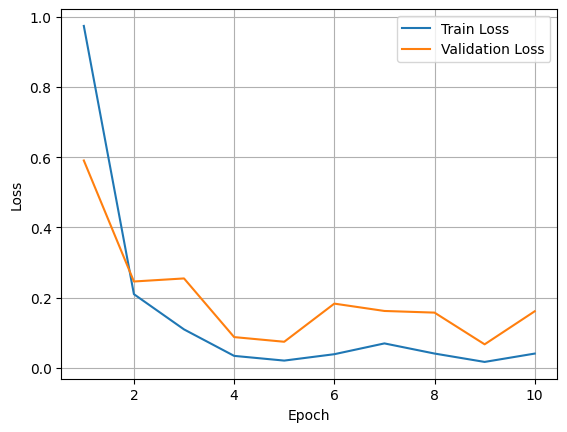

In [15]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Evaluate

In [16]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

    accuracy = correct / total
    return accuracy, torch.cat(all_preds), torch.cat(all_labels)


In [17]:
test_acc, y_pred, y_true = evaluate(model, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.943


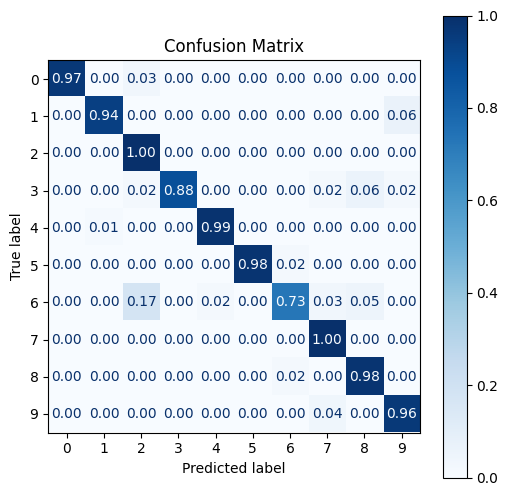

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix")
plt.show()

In [19]:
torch.save(model.state_dict(), "googlenet-audio-mnist-spec.pth")